# **Preprocess Actigraphy Data**

### Imports

In [1]:
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
from scipy import stats

# **Prepare Actigraphy Data**

In [2]:
all_suj = glob.glob('../data/**/*.json', recursive=True)
print(len(all_suj))
all_suj[:10]

1964


['../data\\BOGN00001\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00002\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00003\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00004\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00005\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00006\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00007\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00008\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00009\\minbymin\\min_2018-04-01-2019-08-30.json',
 '../data\\BOGN00010\\minbymin\\min_2018-04-01-2019-08-30.json']

### Actigraphy for the [STAGES dataset](https://sleepdata.org/datasets/stages) is in JSON format.
We need to convert to DataFrame

In [3]:
def extract_json_from_response(text):
    # Find the start of the JSON part (first occurrence of '{')
    start_index = text.find('{')
    if start_index == -1:
        return None  # JSON start character not found
    # Extract the JSON string
    json_str = text[start_index:]
    return json_str

def clean_and_load_json_from_file(filepath):
    with open(filepath, 'r') as file:
        text = file.read()
    # Now `text` contains the content of your file, and we can process it as before
    cleaned_json_str = extract_json_from_response(text)
    if cleaned_json_str is None:
        print("No JSON content found.")
        return None
    try:
        data = json.loads(cleaned_json_str)
        df = pd.json_normalize(data, record_path=['items'])
        return df
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return None

### The software calculates:
- Activeness
- Steps
- Mode (unknown)

and records measurements every few minutes

In [75]:
suj = 123
print(all_suj[suj])
df = clean_and_load_json_from_file(all_suj[suj])
df.head()

../data\GSBB00029\minbymin\min_2018-04-01-2019-08-30.json


,date,minute,lastSyncTime,activeness,mode,steps
0,2019-05-30,1176,1559174400,31,0,0
1,2019-05-30,1177,1559174400,25,0,0
2,2019-05-30,1178,1559174400,27,0,0
3,2019-05-30,1179,1559174400,5,0,0
4,2019-05-30,1180,1559174400,22,0,0


In [76]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['minute'] // 60

# Create a datetime column by adding the hours and minutes to the 'date'
df['datetime'] = df['date'] + pd.to_timedelta(df['hour'] , unit='h') + pd.to_timedelta(df['minute'], unit='m')
print(df.shape)
df.head()

(20020, 8)


,date,minute,lastSyncTime,activeness,mode,steps,hour,datetime
0,2019-05-30,1176,1559174400,31,0,0,19,2019-05-31 14:36:00
1,2019-05-30,1177,1559174400,25,0,0,19,2019-05-31 14:37:00
2,2019-05-30,1178,1559174400,27,0,0,19,2019-05-31 14:38:00
3,2019-05-30,1179,1559174400,5,0,0,19,2019-05-31 14:39:00
4,2019-05-30,1180,1559174400,22,0,0,19,2019-05-31 14:40:00


In [77]:
scaler = MinMaxScaler()
df[['activeness', 'steps']] = scaler.fit_transform(df[['activeness', 'steps']])

# **Plot a single patient's Actigraphy (2 weeks)**

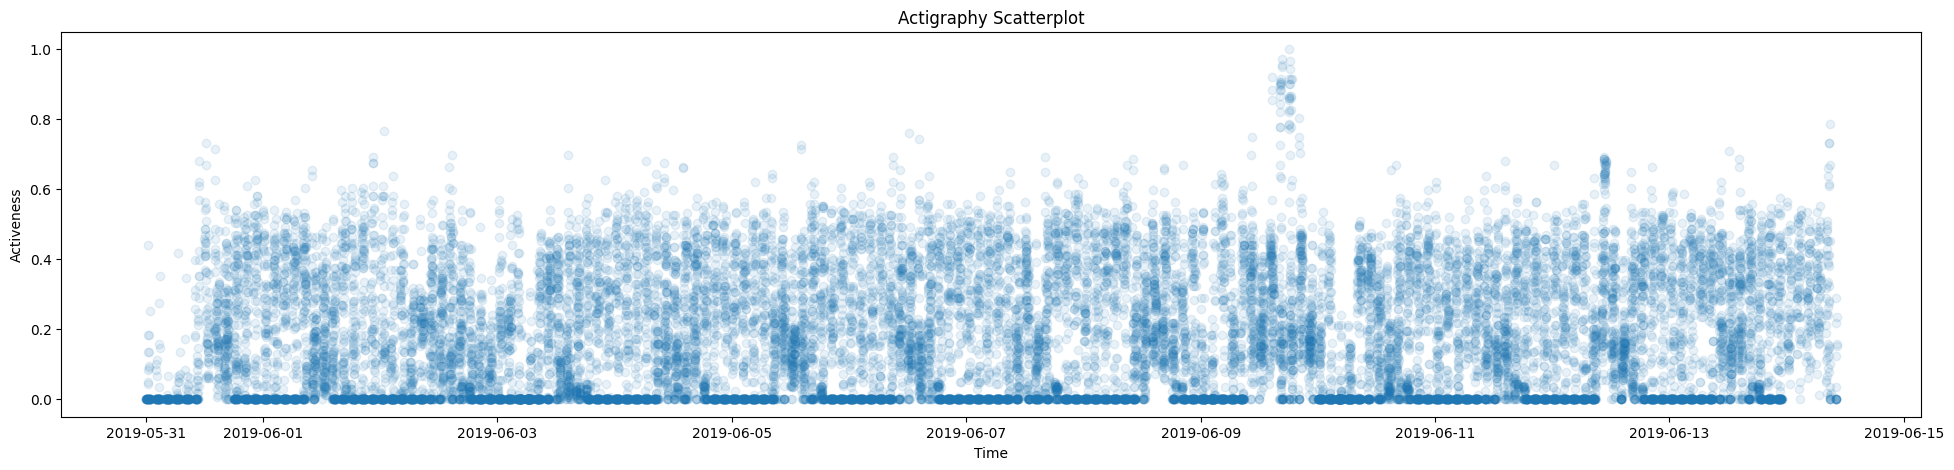

In [103]:
plt.figure(figsize=(24,5))
plt.scatter(df['datetime'], df['activeness'], alpha=.1)
plt.xlabel('Time')
plt.ylabel('Activeness')
plt.title('Actigraphy Scatterplot')
plt.show()

# **Validate Sleep vs. Wake Detection by Tracking Recording Days**

- Since there are no labels for sleeping vs. wakefulness, we need to upperbound the number of sleep cycles detected later on.
- Real data may have periods of missing data, so we need to account for that or omit patients with poor data.

In [80]:
# Ensure the dataframe is sorted by 'date'
df.sort_values(by='date', inplace=True)

# Calculate the difference between each date and the previous date
df['date_diff'] = df['date'].diff()

# Count the total number of unique days
total_days = df['date'].nunique()

# Identify skipped days (any gap greater than 1 day)
skipped_days_count = (df['date_diff'] > pd.Timedelta(days=1)).sum()

# Number of days covered in the dataset
days_covered = (df['date'].max() - df['date'].min()).days + 1

print(f"Total unique days in the dataset: {total_days}")
print(f"Number of days covered from start to end: {days_covered}")
print(f"Number of skipped days: {skipped_days_count}")

# If you want to know which days were skipped
if skipped_days_count > 0:
    skipped_dates = [df['date'].min() + pd.Timedelta(days=x) for x in range(days_covered) if not ((df['date'].min() + pd.Timedelta(days=x)) in df['date'].values)]
    print(f"Skipped dates: {skipped_dates}")

Total unique days in the dataset: 15
Number of days covered from start to end: 15
Number of skipped days: 0


# **Visualize Actigraphy Data Aggregated Across All Days**

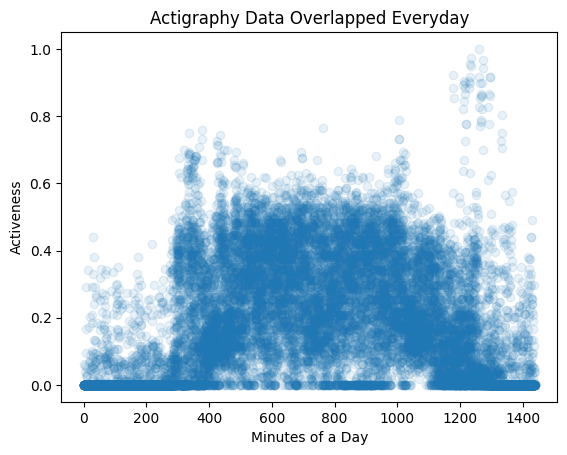

In [81]:
# Simple scatter plot to visualize (adjust features if desired)
plt.scatter(df['minute'], df['activeness'], alpha=.1)
plt.xlabel('Minutes of a Day')
plt.ylabel('Activeness')
plt.title('Actigraphy Data Overlapped Everyday')
plt.show()

# **Visualize Kernel Density Estimation**
I'm going to try to determine sleeping with Gaussian kernel density estimation. Observe the hot-zones, which represent regions of sleeping activity. We can threshold the heat and develop bounds for periods of sleep. Finally we use those bounds to add a new column to the dataframe for sleep vs. wake.

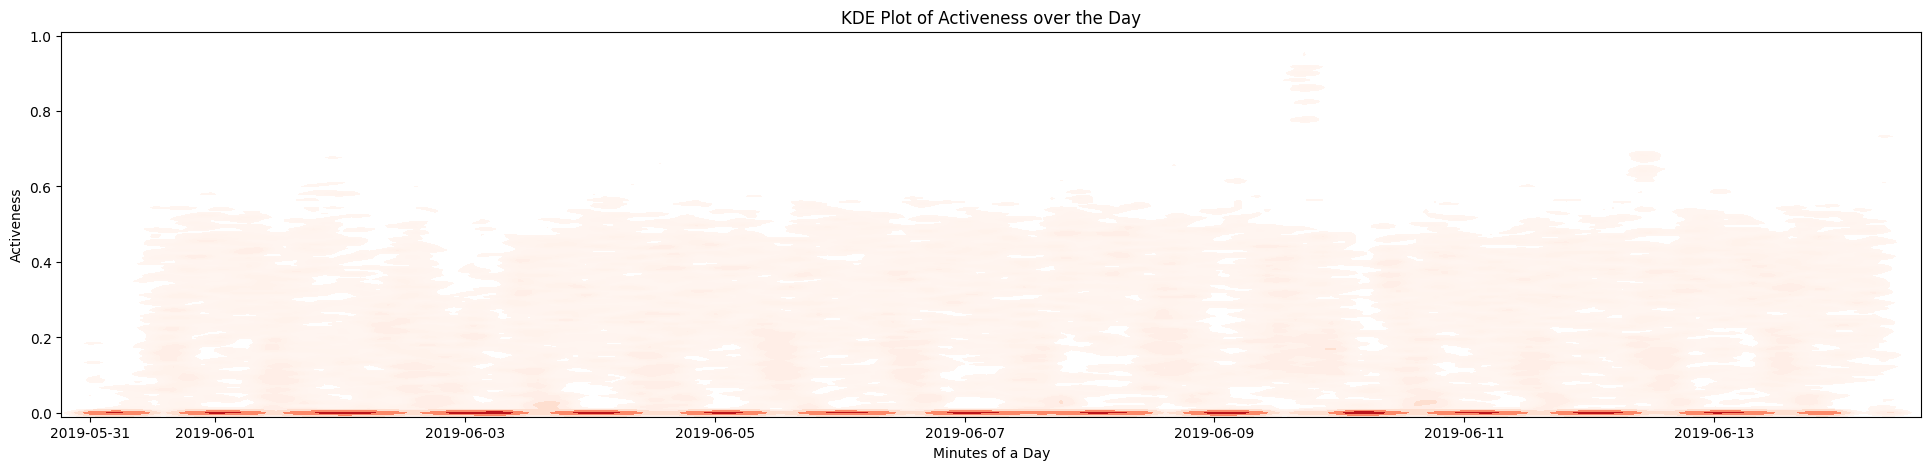

In [82]:
# Create the KDE plot
plt.figure(figsize=(24,5))
sns.kdeplot(data=df, x='datetime', y='activeness', cmap="Reds", fill=True, bw_adjust=.1)
plt.title('KDE Plot of Activeness over the Day')
plt.xlabel('Minutes of a Day')
plt.ylabel('Activeness')

# Show the plot
plt.show()

## We may encounter outlier hot-zones in poor data, so should add another algorithm to find peaks in this cyclical context.
I will use the [bycycle](https://bycycle-tools.github.io/bycycle/index.html) Python library for this. This geometrical approach for determining bounds is more robust.

In [88]:
# Convert 'DateTime' to a numerical format (e.g., minutes since the start of the recording)
df['TimeNumeric'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds() / 60

# Compute the KDE using gaussian_kde
kde = stats.gaussian_kde(dataset=(df['TimeNumeric'], df['activeness']), bw_method=0.1)

# Evaluate KDE on a grid
time_grid = np.linspace(df['TimeNumeric'].min(), df['TimeNumeric'].max(), 1000)
activeness_grid = np.linspace(df['activeness'].min(), df['activeness'].max(), 1000)
time_grid, activeness_grid = np.meshgrid(time_grid, activeness_grid)
kde_values = kde(np.vstack([time_grid.ravel(), activeness_grid.ravel()]))

In [91]:
# Convert 'DateTime' to a numerical format (e.g., minutes since the start of the recording)
df['TimeNumeric'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds() / 60

# Set up the grid for evaluation
time_grid = np.linspace(df['TimeNumeric'].min(), df['TimeNumeric'].max(), 1000)
activeness_grid = np.linspace(df['activeness'].min(), df['activeness'].max(), 1000)

# Generate a 2D grid of points to evaluate the KDE on
time_grid_2d, activeness_grid_2d = np.meshgrid(time_grid, activeness_grid)
grid_points = np.vstack([time_grid_2d.ravel(), activeness_grid_2d.ravel()])

# Compute the KDE
kde = stats.gaussian_kde(dataset=[df['TimeNumeric'], df['activeness']], bw_method=0.02)
kde_values = kde(grid_points)

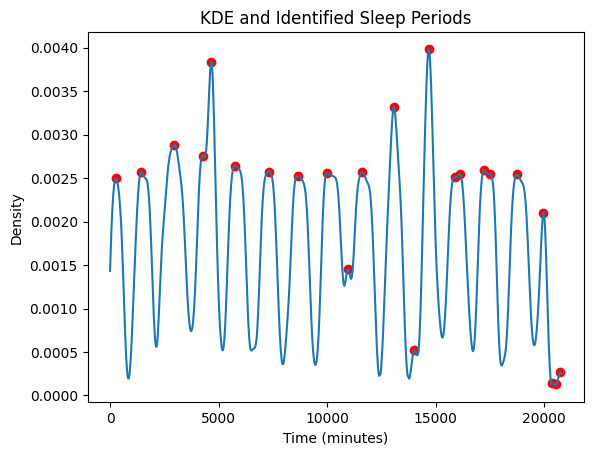

In [92]:
# Now we can reshape the kde_values into a 2D grid
Z = kde_values.reshape(time_grid_2d.shape)

# Integrate over the 'activeness' axis to find the total density at each time point
density_over_time = Z.max(axis=0)

# Find peaks in the density
peaks, _ = find_peaks(density_over_time)

# Use the peaks to find low-density regions which might correspond to sleep
# For simplicity, we might assume that the regions between peaks are sleep periods
sleep_periods = np.diff(peaks) > np.median(np.diff(peaks)) * 1.5  # Threshold can be adjusted
sleep_indices = peaks[:-1][sleep_periods]  # Start of each sleep period

# Now, you can use these indices to define regions in your original DataFrame as sleep periods
# This would require mapping the indices from the KDE back to your actual timeseries indices

plt.plot(time_grid, density_over_time)
plt.scatter(time_grid[peaks], density_over_time[peaks], color='r')  # Peaks in red
plt.scatter(time_grid[sleep_indices], density_over_time[sleep_indices], color='g')  # Sleep starts in green
plt.xlabel('Time (minutes)')
plt.ylabel('Density')
plt.title('KDE and Identified Sleep Periods')
plt.show()

C:\Users\khngu\AppData\Local\Temp\ipykernel_46264\123420377.py:5: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  timestamps = sleep_data['datetime'].view(np.int64)


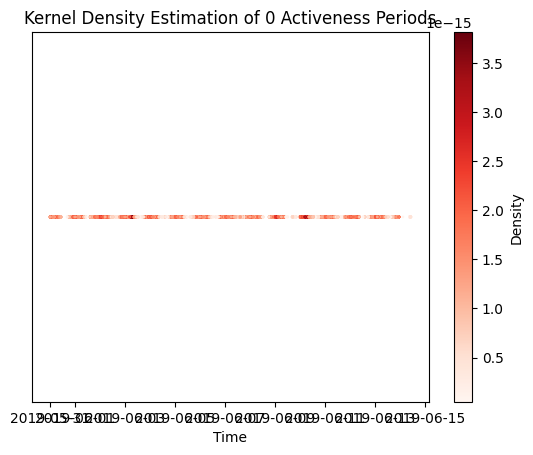

In [93]:
# Filter to only rows with 0 activeness
sleep_data = df[df['activeness'] == 0]

# KDE requires numerical input, so convert datetime to a numerical format (e.g., Unix timestamp)
timestamps = sleep_data['datetime'].view(np.int64)

# Apply KDE
kde = stats.gaussian_kde(timestamps)
kde.set_bandwidth(bw_method=kde.factor/50.)

# Evaluate the density on a grid of the same timestamps to identify hot zones
densities = kde(timestamps)

# Plotting for visualization
# plt.figure(figsize=(10, 6))
plt.scatter(sleep_data['datetime'], np.zeros_like(timestamps), c=densities, cmap='Reds', s=1)
plt.colorbar(label='Density')
plt.title('Kernel Density Estimation of 0 Activeness Periods')
plt.xlabel('Time')
plt.yticks([])
plt.show()

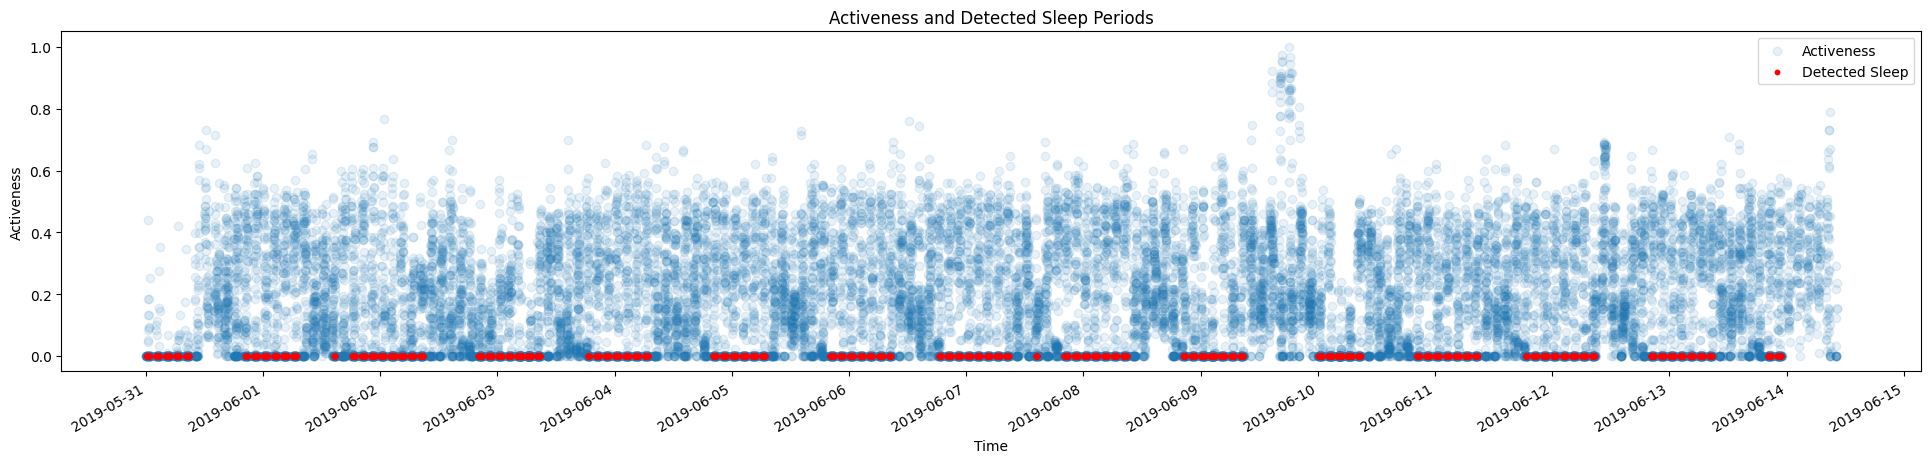

In [145]:
# Thresholding to determine hot zones might be based on density percentiles, e.g., top 25%
threshold = np.percentile(densities, 33)

# Label the original data based on whether the timestamp falls within a hot zone
df['timestamp'] = df['datetime'].astype('int64') // 10**9  # Convert nanoseconds to seconds

# Convert timestamps back to datetime for plotting
sleep_datetimes = pd.to_datetime(sleep_data['datetime'])

# Create a boolean mask for sleep periods based on the density threshold
is_sleep = densities >= threshold

# Now let's adjust the final labeling step
df['sleep_wake_label'] = df.apply(lambda row: 'sleep' if row.name in df[df['activeness'] == 0][is_sleep].index.tolist() else 'wake', axis=1)

# Plot the entire dataset
plt.figure(figsize=(24, 5))
plt.scatter(df['datetime'], df['activeness'], label='Activeness', alpha=0.1)

# Overlay sleep periods
# Note: For clarity, 'sleep_datetimes' and 'is_sleep' are from the filtered sleep_data,
# You may need to adjust to plot against the full dataset, depending on your exact requirements
plt.scatter(sleep_datetimes[is_sleep], np.zeros(sum(is_sleep)), color='red', s=10, label='Detected Sleep')

plt.title('Activeness and Detected Sleep Periods')
plt.xlabel('Time')
plt.ylabel('Activeness')
plt.legend()

# Formatting datetime x-axis (this depends on the range of your data)
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate() # Rotation

plt.show()

In [147]:
df['sleep_wake_label'].value_counts()

sleep_wake_label
wake     15724
sleep     4296
Name: count, dtype: int64

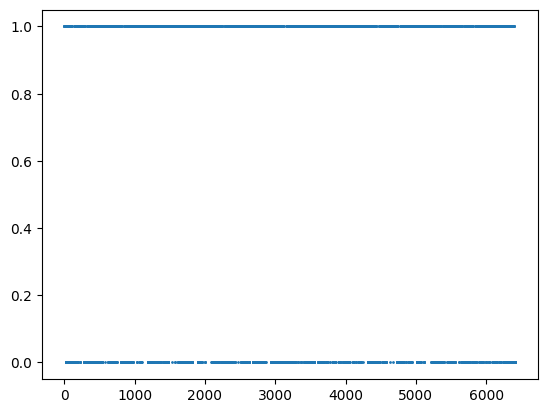

In [120]:
plt.scatter(np.arange(is_sleep.size), is_sleep, s=1)